In [175]:
# !pip install yargy
# !pip install pandas
# !pip install xgboosyt
# !pip install -U scikit-learn

import pandas as pd

# Определяем путь до данных
path_to_folder = 'preprocessing_data_big.csv'

data = pd.read_csv(path_to_folder, sep='@')
data = data[['task', 'topic', 'new_task']]

# Подготовка

In [252]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import warnings
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.util import ngrams

from sklearn.preprocessing import OneHotEncoder
from yargy import Parser, rule, and_, or_
from yargy.predicates import gram
from yargy.interpretation import fact, attribute
from yargy.predicates import normalized, dictionary
from yargy.pipelines import morph_pipeline
from yargy.relations import main
from yargy.predicates import in_

from tqdm import tqdm

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [254]:
Case = fact('Case', ['name'])
Word = gram('Word')


def split_data(data):
    """
    Функция, которая разделяет датасет на тренировочную и тестовую выборку
    """
    x, y = data[[column for column in data.columns if column != 'y']], data['y']
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
    return X_train, X_test, y_train, y_test


def get_ml_metrics(data, name, X_columns='new_task', y_columns='topic',
                   tf_idf=True, need_processin=True,
                   accuracy=False):
    """
    Функция, которая обучает XGBClassifier и возвращает метрику f1-score
    """
    if need_processin:
        data_proc = preprocessing_data(data=data, name=name, X_columns='new_task', y_columns='topic', tf_idf=tf_idf)
    else:
        data_proc = data
    X_train, X_test, y_train, y_test = split_data(data_proc)
    model = XGBClassifier(max_depth=7, random_state=42, n_estimators=500)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    if accuracy:
        return model, accuracy_score(y_test, y_pred)
    return model, f1_score(y_test, y_pred, average='binary')


def vect_tfidf(vectorizer, text):
    """
    Функция, которая добавляет векторное представлние текста с помощью модели vectorizer
    """
    return vectorizer.transform([text]).toarray()


def preprocessing_data(data, name, X_columns='new_task', y_columns='topic', tf_idf=True):
    """
    Функция, которая векторизует датасет
    """

    # Векторизируем целевую переменную
    data['y'] = data[y_columns].apply(lambda topic_name: 1 if topic_name == name else 0)

    if tf_idf:
        # Векторизуем текст с помощью Tf-Idf
        learn_tf_idf = list(data['new_task'].apply(lambda text: text.lower().split()))

        vectorizer = TfidfVectorizer(max_features=5000, min_df=3)
        vectorizer = vectorizer.fit(data[X_columns])

        train_title_tfidf = np.vstack(data[X_columns].apply(lambda x: vect_tfidf(vectorizer, x)))
        for i in range(len(vectorizer.get_feature_names_out())):
            data[f"Tiidf title f.{i + 1}"] = train_title_tfidf[:, i]

    # Возвращаем обработанный датасет
    data.drop(columns=[X_columns, y_columns], inplace=True)
    return data

def get_word_cloud(data, topic):
    """
    Функция, которая строит облако слов
    """
    df = data[data.topic == topic]
    text = ' '.join(df['new_task'])
    text_tokens = word_tokenize(text)
    cloud = WordCloud(stopwords=stop_words,
                      background_color='white').generate(' '.join(text_tokens))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(topic)
    plt.show()


def get_n_grams(data, topic, n, k, start_slice=0):
    """
    Функция, которая строит график n-grams
    """
    df = data[data.topic == topic]
    words = ' '.join(df.new_task)
    words = ' '.join(list(filter(lambda x: len(x) >= 2, (words.split()))))
    tokens = nltk.word_tokenize(words)

    ngrams_list = list(ngrams(tokens, n))
    freq_dist = dict(FreqDist(ngrams_list))
    sorted_data = sorted(freq_dist.items(), key=lambda x: -x[1])

    y_labels = [str(key) for key, _ in sorted_data][start_slice:start_slice+k][::-1]
    x_values = [value for _, value in sorted_data][start_slice:start_slice+k][::-1]

    plt.barh(y_labels, x_values)
    plt.xlabel('Значение')
    plt.ylabel('N-grams')
    plt.title(topic)
    plt.show()



def extract_phrases(text, parser):
    """
    Функция для извлечения словосочетаний из текста
    """
    matches = parser.findall(text)
    phrases = []
    for match in matches:
        phrases.append(' '.join([word.value for word in match.tokens]))
    return phrases


def make_topic_one_to_one(topic: list):
    """
    Функция для формирования pipline слова
    """
    return morph_pipeline(topic).interpretation(
          Case.name.const(topic[0])
      ).interpretation(
          Case
      )


def add_keywords(df, keywords, column_name):
    """
    Функция, которая добавляет ключевые слова в dataset
    """
    if type(keywords[0]) is tuple:
        alls_word_pipe = []
        for word in keywords:
            alls_word_pipe.append(make_topic_one_to_one(["".join(word)]))
            df[word] = np.NaN

        ALL = or_(*alls_word_pipe).interpretation(Case)
        parser = Parser(ALL)

        for ind, elem in enumerate(tqdm(df[column_name])):
            for match in parser.findall(str(elem)):
                df.loc[ind, match.fact] = 1
        result_df = df
    else:
        alls_word_pipe = []
        for word in keywords:
            alls_word_pipe.append(make_topic_one_to_one([word]))
            df[word] = np.NaN

        ALL = or_(*alls_word_pipe).interpretation(Case)
        parser = Parser(ALL)

        for ind, elem in enumerate(tqdm(df[column_name])):
            for match in parser.findall(str(elem)):
                df.loc[ind, match.fact] = 1
        result_df = df
    result_df.fillna(0, inplace=True)
    return result_df

def visualization_feature_importances(model, data, top_k=10):
    '''
    Функция, которая визуализирует важность признаков модели

    Параметры:
      model - обученная модель
      data - данные, на которых обучалась модель
      top_k - количество первых признаков для отображения (по умолчанию 10)
    '''

    feature_importance = model.feature_importances_
    feature_names = [x for x in data.columns if x != 'y']

    sorted_idx = np.argsort(feature_importance)[::-1]  # Изменяем порядок сортировки

    plt.figure(figsize=(10, 6))

    plt.barh(range(top_k),
             feature_importance[sorted_idx][:top_k],  # Взять только первые top_k значений
             align='center')

    plt.yticks(range(top_k),
               [feature_names[i] for i in sorted_idx][:top_k],  # Взять только первые top_k признаков
               fontsize=10)

    plt.xlabel('Важность факторов')
    plt.ylabel('Факторы')
    plt.title('График важности факторов')

    plt.show()

    return [feature_names[i] for i in sorted_idx][:top_k][::-1]  # Вернуть только первые top_k признаков в обратном порядке


# def featuring_selection(columns_to_train, name, columns, data, need_processin):
#     """
#     Функция, которая выбирает лучшее количество фич
#     """
#     max_score = 0
#     best_top_k = 0
#     for top_k in range(0, len(columns) - 1):
#         data_1_3 = data[columns_to_train[top_k:]]
#         model, score = get_ml_metrics(data_1_3, name='Геометрия', X_columns='new_task',
#                                       y_columns='topic', tf_idf=False, need_processin=need_processin)
#         if score >= max_score:
#           max_score = score
#           best_top_k = len(columns) - 1 - top_k
#         print(f"iter - {top_k}, первая колонка - {columns_to_train[top_k:][0]}, score - {score}, max_score - {max_score}")
#     print(max_score, best_top_k)
#     return max_score, best_top_k

# Анализ данных

Анализируем облако слов, их частоность, n-grams, чтобы выделить ключевые слова

## Геометрия

### Анализ

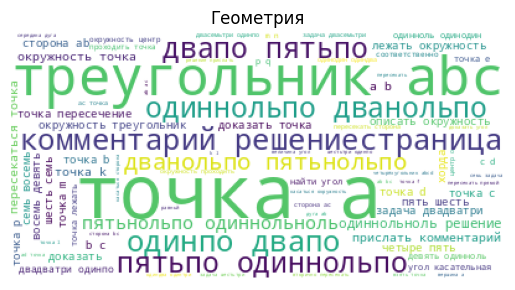

In [ ]:
get_word_cloud(data=data, topic='Геометрия')

In [ ]:
# Массив ключевых слов
geoma_array_1 = [
    "окружность", "угол", "доказать", "треугольник", "пересекаться", "сторона", "центр",
    "точка", "параллельность", "хорда", "вершина", "высота", "пересечение", "прямая",
    "касательная", "лежать", "проходить", 'четырехугольник', 'дуга', 'середина'
]

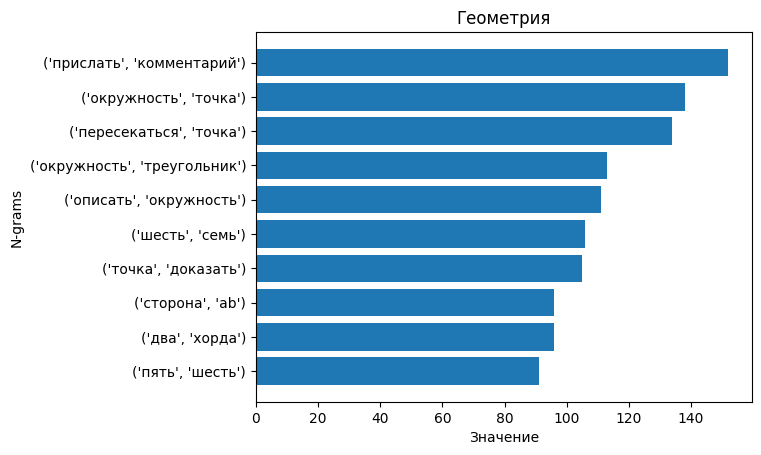

In [ ]:
# Анализ 2-grams
get_n_grams(data=data, topic='Геометрия', n=2, k=10, start_slice=10)

In [ ]:
# Массив ключевых словосочетаний
geoma_2_grams = [
    ("треугольник", "abc"), ("точка", "лежать"), ("окружность", "точка"), ("пересекаться", "точка"),
    ("окружность", "треугольник"), ("описать", "окружность"), ("лежать", "окружность"), ("угол", "касательная"),
    ("окружность", "проходить"), ("окружность", "проходить"),  ("касаться", "окружность"), ("остроугольный", "треугольник"),
    ("прямоугольный", "треугольник"), ("тупоугольный", "треугольник"), ("вписать", "окружность")
]

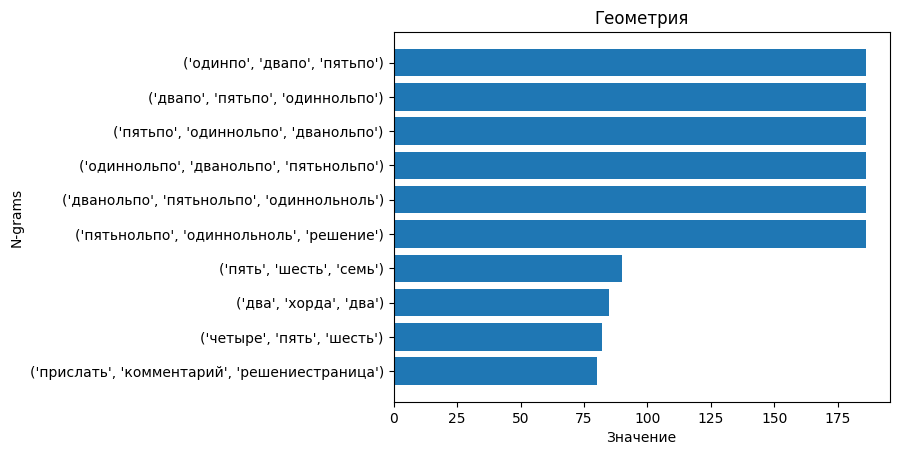

In [ ]:
# Анализ 3-grams
get_n_grams(data=data, topic='Геометрия', n=3, k=10, start_slice=0)

### Отбор признаков

In [ ]:
# Добавляем отобранные слова
data_1 = add_keywords(df=data, keywords=geoma_array_1, column_name='task')
data_1 = add_keywords(df=data_1, keywords=geoma_2_grams, column_name='task')

100%|██████████| 5616/5616 [05:07<00:00, 18.26it/s]


In [ ]:
data_1.to_csv('geoma_1.csv', sep='@')

In [ ]:
# Обучаем на всех признаках
data_1_1 = data_1[[column for column in data_1.columns if column != 'task' and 'title' not in column]]
data_1_2 = data_1_1.copy()

In [ ]:
model, score = get_ml_metrics(data_1_2, name='Геометрия', X_columns='new_task', y_columns='topic', tf_idf=False)
print(score)

0.896551724137931


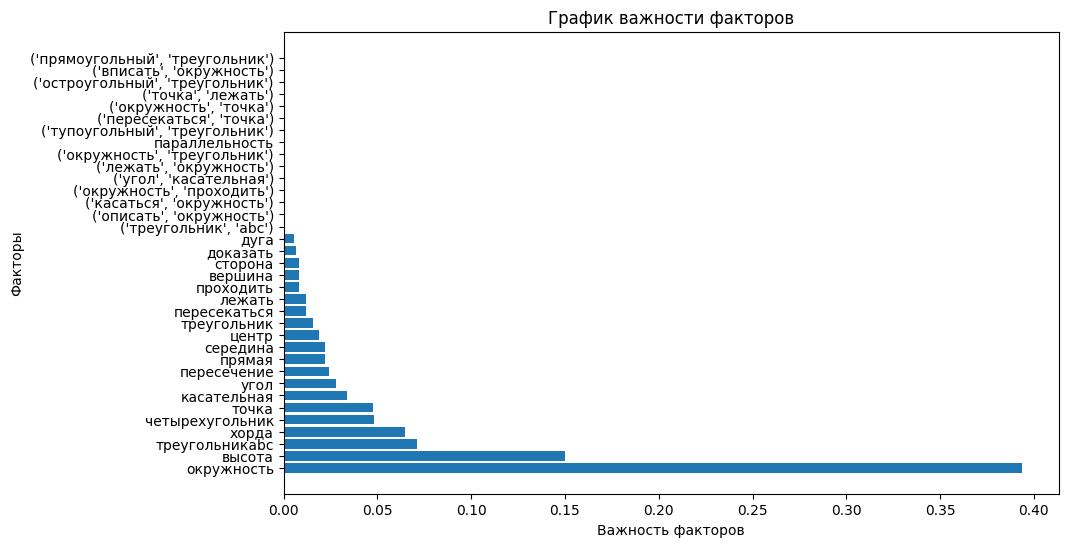

In [ ]:
columns_to_train = visualization_feature_importances(model=model, data=data_1_2, top_k=35)

In [ ]:
# Выбираем лучшее количество фич
columns_to_train = columns_to_train[::-1]
columns_to_train_1 = columns_to_train.copy()
columns_to_train_1.append('topic')
columns_to_train_1.append('new_task')
max_score = 0
best_top_k = 0
for top_k in range(0, len(data_1_2.columns) - 1):
    data_1_3 = data_1_1[columns_to_train_1[top_k:]]
    model, score = get_ml_metrics(data_1_3, name='Геометрия', X_columns='new_task', y_columns='topic', tf_idf=False)
    if score >= max_score:
      max_score = score
      best_top_k = len(data_1_2.columns) - 1 - top_k
    print(f"iter - {top_k}, первая колонка - {columns_to_train_1[top_k:][0]}, score - {score}, max_score - {max_score}")
print(max_score, best_top_k)

iter - 0, первая колонка - ('прямоугольный', 'треугольник'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 1, первая колонка - ('вписать', 'окружность'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 2, первая колонка - ('остроугольный', 'треугольник'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 3, первая колонка - ('точка', 'лежать'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 4, первая колонка - ('окружность', 'точка'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 5, первая колонка - ('пересекаться', 'точка'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 6, первая колонка - ('тупоугольный', 'треугольник'), score - 0.896551724137931, max_score - 0.896551724137931
iter - 7, первая колонка - параллельность, score - 0.896551724137931, max_score - 0.896551724137931
iter - 8, первая колонка - ('окружность', 'треугольник'), score - 0.896551724137931, max_score - 0.896551724137

In [ ]:
columns_to_train[::-1][:16]

['окружность',
 'высота',
 'треугольникabc',
 'хорда',
 'четырехугольник',
 'точка',
 'касательная',
 'угол',
 'пересечение',
 'прямая',
 'середина',
 'центр',
 'треугольник',
 'пересекаться',
 'лежать',
 'проходить']

In [ ]:
geoma_final_featuring = ['окружность', 'высота', 'треугольникabc', 'хорда', 'четырехугольник',
                         'точка', 'касательная', 'угол', 'пересечение', 'прямая', 'середина',
                         'центр', 'треугольник', 'пересекаться', 'лежать', 'проходить']

In [ ]:
# Получаем score модели c tf-idf
featuring_to_learn = geoma_final_featuring + ['topic',	'new_task']
model, score = get_ml_metrics(data_1[featuring_to_learn], name='Геометрия', X_columns='new_task', y_columns='topic')
print(score)

0.9252336448598131


## Дирихле

### Анализ

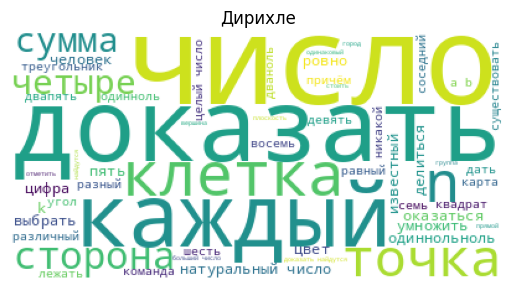

In [ ]:
get_word_cloud(data=data, topic='Дирихле')

In [46]:
dirichlet_array = ["клетка", "закрасить", "доска", "фишка",
                   "сумма", "выбрать", "делиться", "известный",
                   'существует', 'каждый', 'цвет', 'таблица',
                   'найдется', 'больший', 'малый', 'различный',
                   'число', 'оказаться', 'красить']

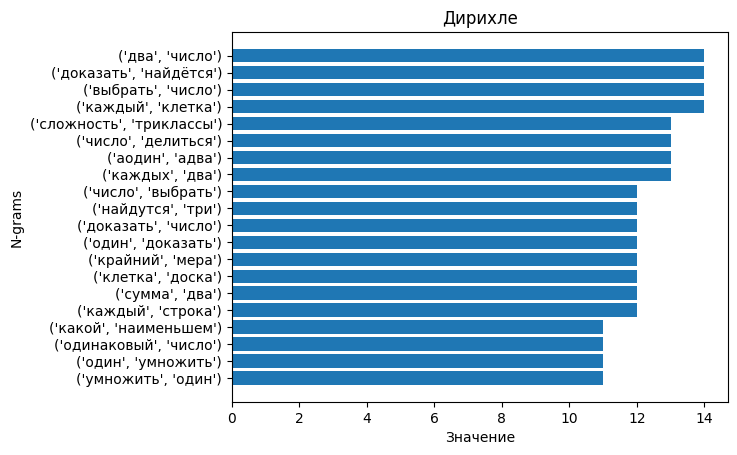

In [ ]:
get_n_grams(data=data, topic='Дирихле', n=2, k=20, start_slice=30)

In [45]:
dirichlet_grams = [
    ("найдется", "два"), ("доказать", "найдется"), ("больший", "число"), ("натуральный", "число"),
    ("какой", "малый"), ("описать", "окружность"), ("цвет", "доказать"), ("доказать", "выбрать"),
    ("малый", "количество"), ("число", "доказать"), ("каждый", "клетка"), ('найдутся', 'два'),
    ('доказать', 'выбрать'), ('число', 'выбрать'), ('какой', 'наименьший'), ('какой', 'наибольгий')
]

### Отбор признаков

In [ ]:
# Добавляем отобранные слова
data_2 = add_keywords(df=data, keywords=dirichlet_array, column_name='task')
data_2 = add_keywords(df=data_2, keywords=dirichlet_grams, column_name='task')

In [ ]:
data_2.to_csv('dirichlet_1.csv', sep='@')

In [48]:
data_2 = pd.read_csv('dirichlet_1.csv', sep='@')

In [49]:
data_2 = data_2.drop(columns=['Unnamed: 0'])

In [50]:
# Обучаем на всех признаках
data_2_1 = data_2[[column for column in data_2.columns if column != 'task' and 'title' not in column]]
data_2_2 = data_2_1.copy()

In [81]:
model, score = get_ml_metrics(data_2_2, name='Дирихле', X_columns='new_task', y_columns='topic', tf_idf=False)
print(score)

0.13986013986013984


In [84]:
len(data_2_2.columns)

28

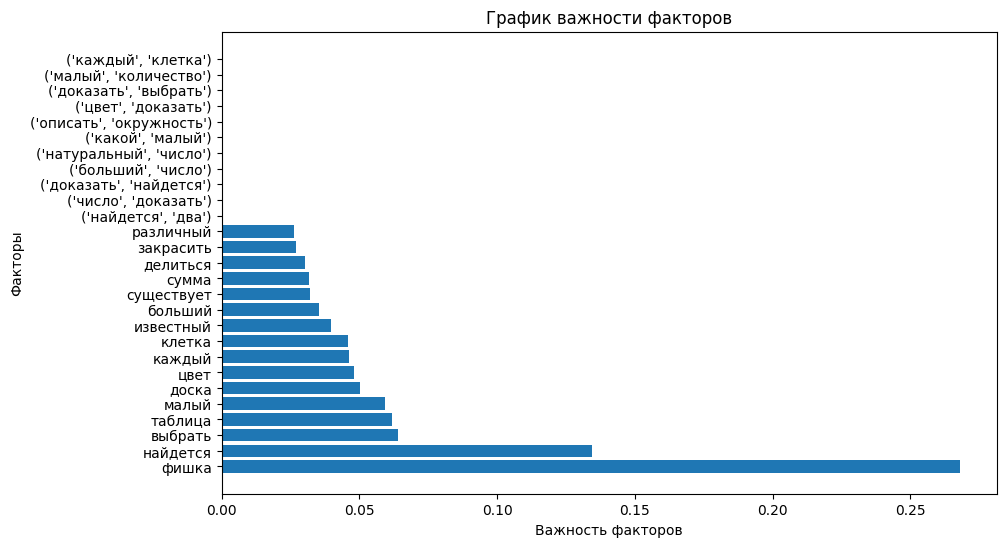

In [86]:
columns_to_train = visualization_feature_importances(model=model, data=data_2_2, top_k=27)

In [106]:
columns_2 = data_2_2.columns

In [110]:
columns_to_train.append('y')

In [115]:
max_score = 0
best_top_k = 0
columns_to_train
for top_k in range(0, len(columns_2) - 1):
    data_1_3 = data_2_2[columns_to_train[top_k:]]
    model, score = get_ml_metrics(data_1_3, name='Геометрия', X_columns='new_task',
                                  y_columns='topic', tf_idf=False, need_processin=False)
    if score >= max_score:
      max_score = score
      best_top_k = len(columns_2) - 1 - top_k
    print(f"iter - {top_k}, первая колонка - {columns_to_train[top_k:][0]}, score - {score}, max_score - {max_score}")

iter - 0, первая колонка - ('каждый', 'клетка'), score - 0.13986013986013984, max_score - 0.13986013986013984
iter - 1, первая колонка - ('малый', 'количество'), score - 0.13986013986013984, max_score - 0.13986013986013984
iter - 2, первая колонка - ('доказать', 'выбрать'), score - 0.13986013986013984, max_score - 0.13986013986013984
iter - 3, первая колонка - ('цвет', 'доказать'), score - 0.13986013986013984, max_score - 0.13986013986013984
iter - 4, первая колонка - ('описать', 'окружность'), score - 0.13986013986013984, max_score - 0.13986013986013984
iter - 5, первая колонка - ('какой', 'малый'), score - 0.13986013986013984, max_score - 0.13986013986013984
iter - 6, первая колонка - ('натуральный', 'число'), score - 0.13986013986013984, max_score - 0.13986013986013984
iter - 7, первая колонка - ('больший', 'число'), score - 0.13986013986013984, max_score - 0.13986013986013984
iter - 8, первая колонка - ('доказать', 'найдется'), score - 0.13986013986013984, max_score - 0.13986013986

In [121]:
dirichlet_final_columns = ['различный', 'закрасить', 'делиться', 'сумма', 'существует',
                           'больший', 'известный', 'клетка', 'каждый', 'цвет', 'доска',
                           'малый', 'таблица', 'выбрать', 'найдется', 'фишка']

In [52]:
model, score = get_ml_metrics(data_2_2, name='Дирихле', X_columns='new_task', y_columns='topic')
print(score)

0.20652173913043478


## Инвариант

### Анализ

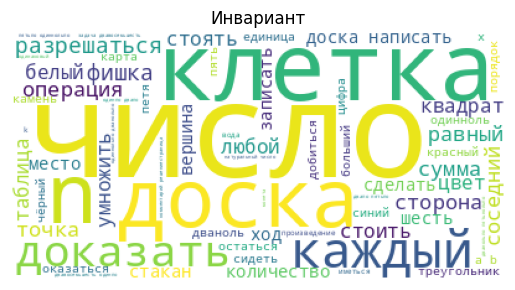

In [122]:
get_word_cloud(data=data, topic='Инвариант')

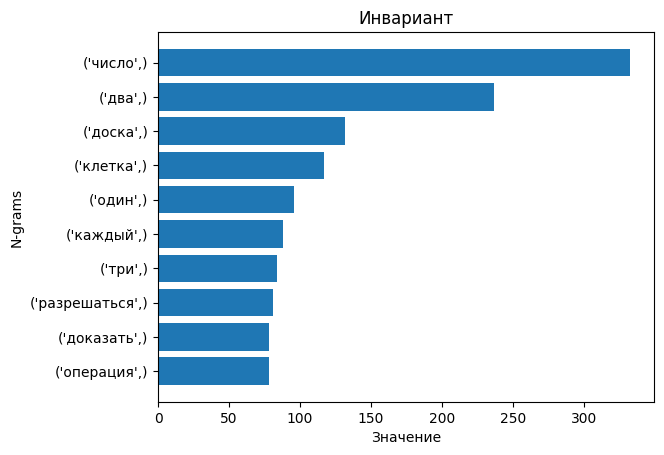

In [129]:
# Анализ 1-grams
get_n_grams(data=data, topic='Инвариант', n=1, k=10, start_slice=0)

In [19]:
invariant_array_1 = ["последовательность", "разрешаться", "равный",
                 "соседний", "стакан", "таблица", "стоить", "операция",
                 "любой", "каждый", "порядок", "количество", "стоять",
                 "оказаться", "место", 'число', "вершина", "ход",
                 "единица", "добиться", 'точка', 'написать',
                 'получить', 'цвет', 'операция']

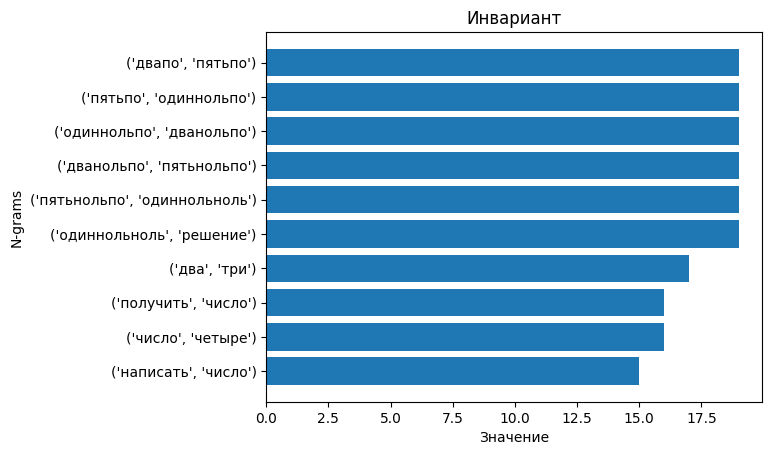

In [132]:
# Анализ 2-grams
get_n_grams(data=data, topic='Инвариант', n=2, k=10, start_slice=10)

In [20]:
invariant_array_2 = [('доска', 'написать')]

### Отбор

In [21]:
# Добавляем отобранные слова
data_3 = add_keywords(df=data, keywords=invariant_array_1, column_name='task')
data_3 = add_keywords(df=data_3, keywords=invariant_array_2, column_name='task')

100%|██████████| 5616/5616 [00:08<00:00, 643.77it/s] 


In [23]:
data_3.to_csv('invariant_1.csv', sep='@')

In [15]:
data_3 = pd.read_csv('invariant_1.csv', sep='@')

In [18]:
data_3.drop(columns=['Unnamed: 0'], inplace=True)

In [19]:
# Обучаем на всех признаках
data_3_1 = data_3[[column for column in data_3.columns if column != 'task' and 'title' not in column]]
data_3_2 = data_3_1.copy()

In [20]:
model, score = get_ml_metrics(data_3_2, name='Инвариант', X_columns='new_task', y_columns='topic', tf_idf=False)
print(score)

0.15053763440860216


In [21]:
len(data_3_2.columns)

26

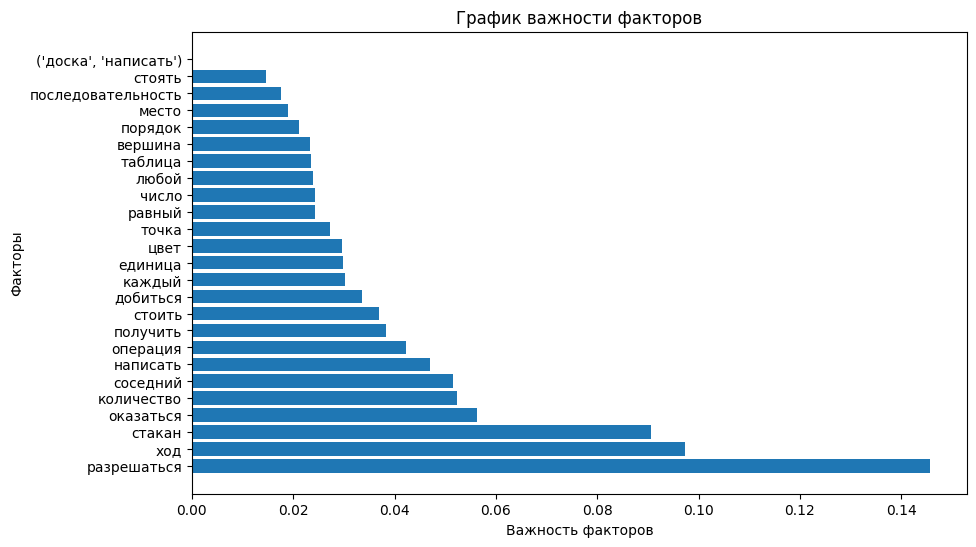

In [25]:
columns_to_train = visualization_feature_importances(model=model, data=data_3_2, top_k=25)

In [28]:
# Выбираем лучшее количество фич
columns_to_train_1 = columns_to_train.copy()
columns_to_train_1.append('y')
max_score = 0
best_top_k = 0
for top_k in range(0, len(data_3_2.columns) - 1):
    data_1_3 = data_3_2[columns_to_train_1[top_k:]]
    model, score = get_ml_metrics(data_1_3, name='Инвариант', X_columns='new_task', y_columns='topic',
                                  tf_idf=False, need_processin=False)
    if score >= max_score:
      max_score = score
      best_top_k = len(data_3_2.columns) - 1 - top_k
    print(f"iter - {top_k}, первая колонка - {columns_to_train_1[top_k:][0]}, score - {score}, max_score - {max_score}")
print(max_score, best_top_k)

iter - 0, первая колонка - ('доска', 'написать'), score - 0.15053763440860216, max_score - 0.15053763440860216
iter - 1, первая колонка - стоять, score - 0.15053763440860216, max_score - 0.15053763440860216
iter - 2, первая колонка - последовательность, score - 0.15217391304347827, max_score - 0.15217391304347827
iter - 3, первая колонка - место, score - 0.19148936170212766, max_score - 0.19148936170212766
iter - 4, первая колонка - порядок, score - 0.17391304347826086, max_score - 0.19148936170212766
iter - 5, первая колонка - вершина, score - 0.2127659574468085, max_score - 0.2127659574468085
iter - 6, первая колонка - таблица, score - 0.1702127659574468, max_score - 0.2127659574468085
iter - 7, первая колонка - любой, score - 0.21052631578947367, max_score - 0.2127659574468085
iter - 8, первая колонка - число, score - 0.2222222222222222, max_score - 0.2222222222222222
iter - 9, первая колонка - равный, score - 0.21978021978021978, max_score - 0.2222222222222222
iter - 10, первая кол

In [30]:
columns_to_train_1[14:]

['добиться',
 'стоить',
 'получить',
 'операция',
 'написать',
 'соседний',
 'количество',
 'оказаться',
 'стакан',
 'ход',
 'разрешаться',
 'y']

In [31]:
invariant_final_columns = ['добиться', 'стоить', 'получить',
                           'операция', 'написать', 'соседний',
                           'количество', 'оказаться', 'стакан','ход',
                           'разрешаться']

In [33]:
data_3_2

,последовательность,разрешаться,равный,соседний,стакан,таблица,стоить,операция,любой,каждый,...,вершина,ход,единица,добиться,точка,написать,получить,цвет,"('доска', 'написать')",y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5614,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [39]:
data_3_3 = data_3_1[invariant_final_columns + ['topic',	'new_task']]

In [41]:
get_ml_metrics(data_3_3, name='Инвариант', X_columns='new_task', y_columns='topic', tf_idf=True)

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=7, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=500, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
 0.22448979591836735)

In [42]:
data_3_3

,добиться,стоить,получить,операция,написать,соседний,количество,оказаться,стакан,ход,...,Tiidf title f.3796,Tiidf title f.3797,Tiidf title f.3798,Tiidf title f.3799,Tiidf title f.3800,Tiidf title f.3801,Tiidf title f.3802,Tiidf title f.3803,Tiidf title f.3804,Tiidf title f.3805
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.281582,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.453358,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


## Многочлен

### Анализ

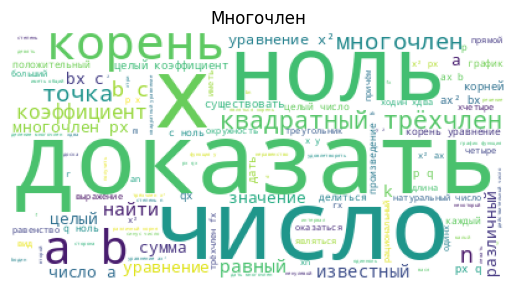

In [53]:
get_word_cloud(data=data, topic='Многочлен')

In [62]:
polynomial_array_1 = ["число", "множители", "корень", "квадратный",
                      "неизвестная","многочлен", "функция", "уравнение", "коэффициент",
                      "кубический", "равенство","неравенство", "член", "трехчлен",
                      "равный", "известный", "равенство", "график", "целый",
                      "положительный", "действительный", "сумма", 'натуральный',
                      "делиться", 'существовать', 'функция', 'произведение'
                    ]

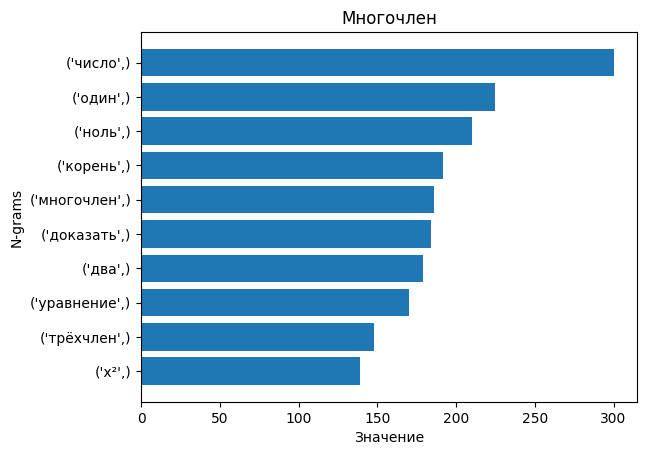

In [61]:
# Анализ 1-grams
get_n_grams(data=data, topic='Многочлен', n=1, k=10, start_slice=0)

### Отбор

In [63]:
data_4 = add_keywords(df=data, keywords=polynomial_array_1, column_name='task')

100%|██████████| 5616/5616 [03:24<00:00, 27.51it/s]


In [ ]:
get_word_cloud(data=data, topic='Комбинаторика')

In [64]:
data_4.to_csv('polynomial_1.csv', sep='@')

In [66]:
# Обучаем на всех признаках
data_4_1 = data_4[[column for column in data_4.columns if column != 'task' and 'title' not in column]]
data_4_2 = data_4_1.copy()

In [68]:
model, score = get_ml_metrics(data_4_2, name='Многочлен', X_columns='new_task', y_columns='topic', tf_idf=False)
print(score)

0.6607142857142857


In [71]:
len(data_4_2.columns)

26

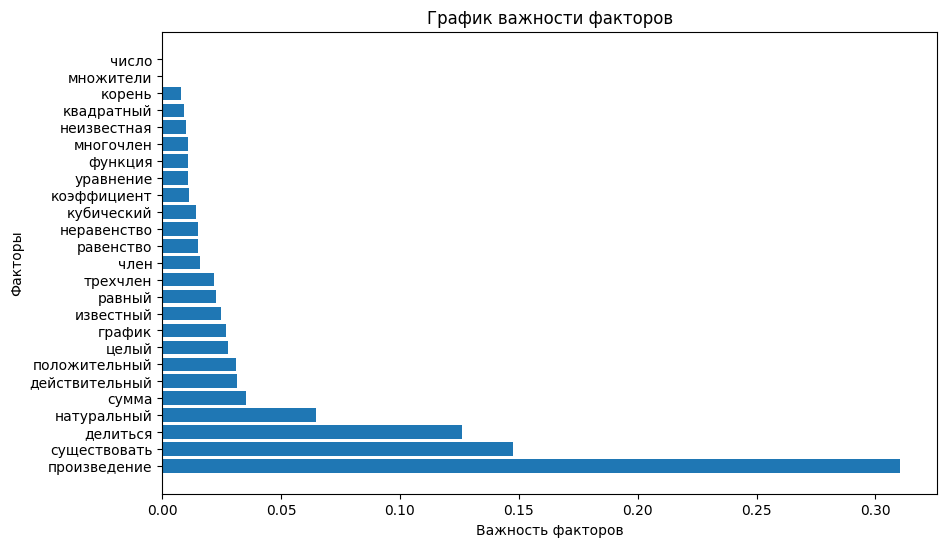

In [80]:
columns_to_train = visualization_feature_importances(model=model, data=data_4_2, top_k=25)

In [81]:
max_score = 0
best_top_k = 0
columns_to_train = columns_to_train + ['y']
for top_k in range(0, len(data_4_2.columns) - 1):
    data_1_3 = data_4_2[columns_to_train[top_k:]]
    model, score = get_ml_metrics(data_1_3, name='Многочлен', X_columns='new_task',
                                  y_columns='topic', tf_idf=False, need_processin=False)
    if score >= max_score:
      max_score = score
      best_top_k = len(data_4_2.columns) - 1 - top_k
    print(f"iter - {top_k}, первая колонка - {columns_to_train[top_k:][0]}, score - {score}, max_score - {max_score}")

iter - 0, первая колонка - число, score - 0.6607142857142857, max_score - 0.6607142857142857
iter - 1, первая колонка - множители, score - 0.6367713004484304, max_score - 0.6607142857142857
iter - 2, первая колонка - корень, score - 0.6607929515418502, max_score - 0.6607929515418502
iter - 3, первая колонка - квадратный, score - 0.6784140969162996, max_score - 0.6784140969162996
iter - 4, первая колонка - неизвестная, score - 0.6784140969162996, max_score - 0.6784140969162996
iter - 5, первая колонка - многочлен, score - 0.6784140969162996, max_score - 0.6784140969162996
iter - 6, первая колонка - функция, score - 0.5346534653465347, max_score - 0.6784140969162996
iter - 7, первая колонка - уравнение, score - 0.5576923076923077, max_score - 0.6784140969162996
iter - 8, первая колонка - коэффициент, score - 0.47668393782383417, max_score - 0.6784140969162996
iter - 9, первая колонка - кубический, score - 0.4111111111111111, max_score - 0.6784140969162996
iter - 10, первая колонка - нера

In [83]:
columns_to_train[5:]

['многочлен',
 'функция',
 'уравнение',
 'коэффициент',
 'кубический',
 'неравенство',
 'равенство',
 'член',
 'трехчлен',
 'равный',
 'известный',
 'график',
 'целый',
 'положительный',
 'действительный',
 'сумма',
 'натуральный',
 'делиться',
 'существовать',
 'произведение',
 'y']

In [84]:
polynomial_final_columns = ['многочлен', 'функция', 'уравнение', 'коэффициент',
                            'кубический', 'неравенство', 'равенство', 'член',
                            'трехчлен', 'равный', 'известный', 'график', 'целый',
                            'положительный', 'действительный', 'сумма', 'натуральный',
                            'делиться', 'существовать', 'произведение']

In [87]:
data_4_3 = data_4_1[polynomial_final_columns + ['topic', 'new_task']]
get_ml_metrics(data_4_3, name='Многочлен', X_columns='new_task', y_columns='topic', tf_idf=True)

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=7, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=500, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
 0.6694915254237288)

## Комбинаторика

### Анализ

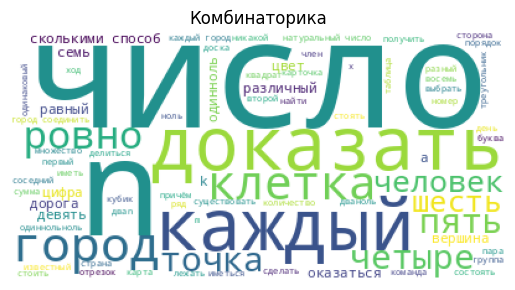

In [89]:
get_word_cloud(data=data, topic='Комбинаторика')

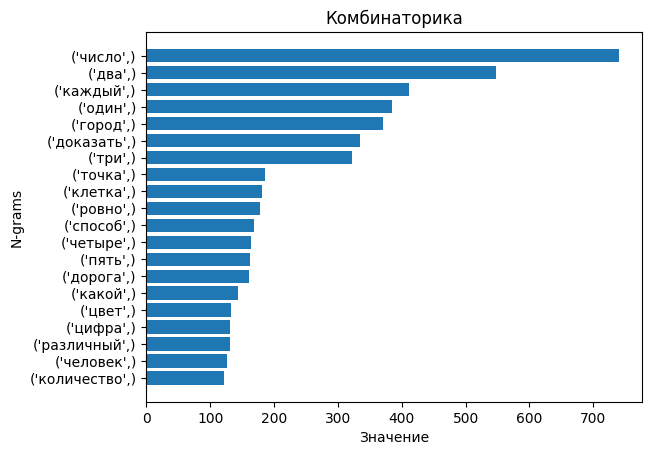

In [94]:
get_n_grams(data=data, topic='Комбинаторика', n=1, k=20, start_slice=0)

In [125]:
combinatorics_array_1 = ["способ", "разделить", "составить", "расставить",
                         "существовать","различный", "порядок", "буква",
                         "ровно", "получить", "состоять", 'сколько',
                         "клетка", "команда", "ровно", "сколькими",
                         "группа", "соседний", "человек", "соединить",
                         "город", 'количество', 'цвет', 'существовать']

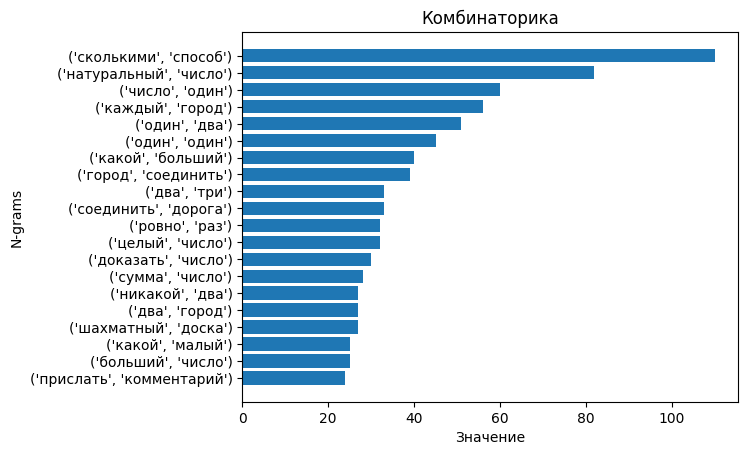

In [99]:
get_n_grams(data=data, topic='Комбинаторика', n=2, k=20, start_slice=0)

In [110]:
combinatorics_array_2 = [("сколькими", "способ")]

### Отбор

In [126]:
# Добавляем отобранные слова
data_5 = add_keywords(df=data, keywords=combinatorics_array_1, column_name='task')
data_5 = add_keywords(df=data_5, keywords=combinatorics_array_2, column_name='task')

100%|██████████| 5616/5616 [00:08<00:00, 625.01it/s] 


In [ ]:
data_5.to_csv("combinatorics_1.csv", sep='@')

In [134]:
# Обучаем на всех признаках
data_5_1 = data_5[[column for column in data_5.columns if column != 'task' and 'title' not in column]]
data_5_2 = data_5_1.copy()

In [135]:
model, score = get_ml_metrics(data_5_2, name='Комбинаторика', X_columns='new_task', y_columns='topic', tf_idf=False)
print(score)

0.3058252427184466


In [136]:
len(data_5_2.columns)

49

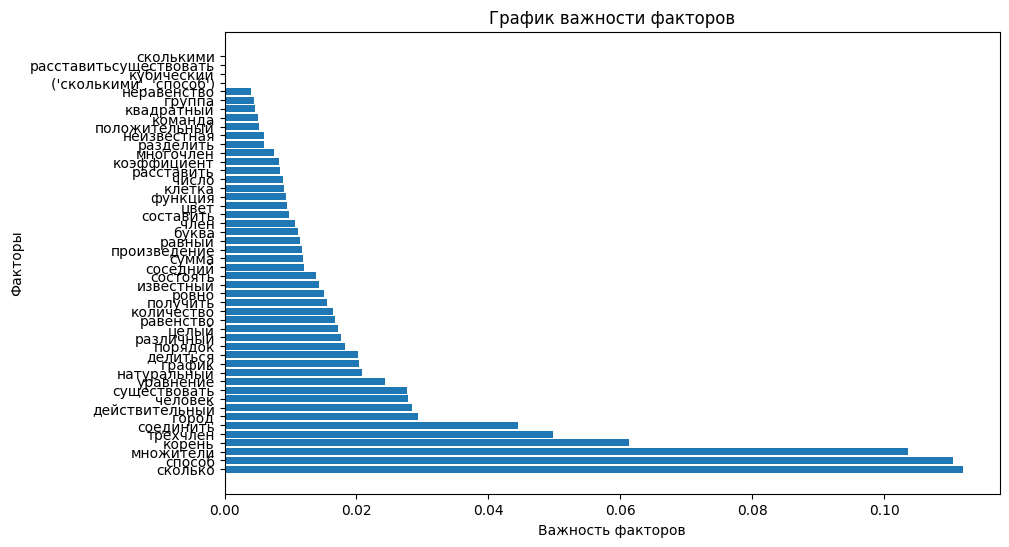

In [138]:
columns_to_train = visualization_feature_importances(model=model, data=data_5_2, top_k=48)

In [140]:
max_score = 0
best_top_k = 0
columns_to_train = columns_to_train + ['y']
for top_k in range(0, len(data_5_2.columns) - 1):
    data_1_3 = data_5_2[columns_to_train[top_k:]]
    model, score = get_ml_metrics(data_1_3, name='Комбинаторика', X_columns='new_task',
                                  y_columns='topic', tf_idf=False, need_processin=False)
    if score >= max_score:
      max_score = score
      best_top_k = len(data_5_2.columns) - 1 - top_k
    print(f"iter - {top_k}, первая колонка - {columns_to_train[top_k:][0]}, score - {score}, max_score - {max_score}")

iter - 0, первая колонка - сколькими, score - 0.3058252427184466, max_score - 0.3058252427184466
iter - 1, первая колонка - расставитьсуществовать, score - 0.3058252427184466, max_score - 0.3058252427184466
iter - 2, первая колонка - кубический, score - 0.3058252427184466, max_score - 0.3058252427184466
iter - 3, первая колонка - ('сколькими', 'способ'), score - 0.3058252427184466, max_score - 0.3058252427184466
iter - 4, первая колонка - неравенство, score - 0.3058252427184466, max_score - 0.3058252427184466
iter - 5, первая колонка - группа, score - 0.29683698296836986, max_score - 0.3058252427184466
iter - 6, первая колонка - квадратный, score - 0.29683698296836986, max_score - 0.3058252427184466
iter - 7, первая колонка - команда, score - 0.2885085574572127, max_score - 0.3058252427184466
iter - 8, первая колонка - положительный, score - 0.3069544364508393, max_score - 0.3069544364508393
iter - 9, первая колонка - неизвестная, score - 0.2815533980582524, max_score - 0.3069544364508

In [142]:
columns_to_train[4:]

['неравенство',
 'группа',
 'квадратный',
 'команда',
 'положительный',
 'неизвестная',
 'разделить',
 'многочлен',
 'коэффициент',
 'расставить',
 'число',
 'клетка',
 'функция',
 'цвет',
 'составить',
 'член',
 'буква',
 'равный',
 'произведение',
 'сумма',
 'соседний',
 'состоять',
 'известный',
 'ровно',
 'получить',
 'количество',
 'равенство',
 'целый',
 'различный',
 'порядок',
 'делиться',
 'график',
 'натуральный',
 'уравнение',
 'существовать',
 'человек',
 'действительный',
 'город',
 'соединить',
 'трехчлен',
 'корень',
 'множители',
 'способ',
 'сколько',
 'y']

In [143]:
combinatorics_final_columns = ['неравенство', 'группа', 'квадратный', 'команда',
                               'положительный', 'неизвестная', 'разделить', 'многочлен',
                               'коэффициент', 'расставить', 'число', 'клетка', 'функция',
                               'цвет', 'составить', 'член', 'буква', 'равный', 'произведение',
                               'сумма', 'соседний', 'состоять', 'известный', 'ровно', 'получить',
                               'количество', 'равенство', 'целый', 'различный', 'порядок',
                               'делиться', 'график', 'натуральный', 'уравнение', 'существовать',
                               'человек', 'действительный', 'город', 'соединить', 'трехчлен',
                               'корень', 'множители', 'способ', 'сколько',
                              ]

## Оценка+Пример

### Анализ

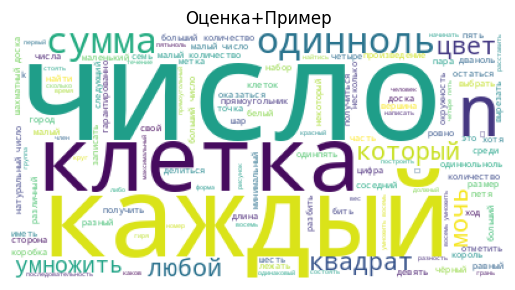

In [178]:
get_word_cloud(data=data, topic='Оценка+Пример')

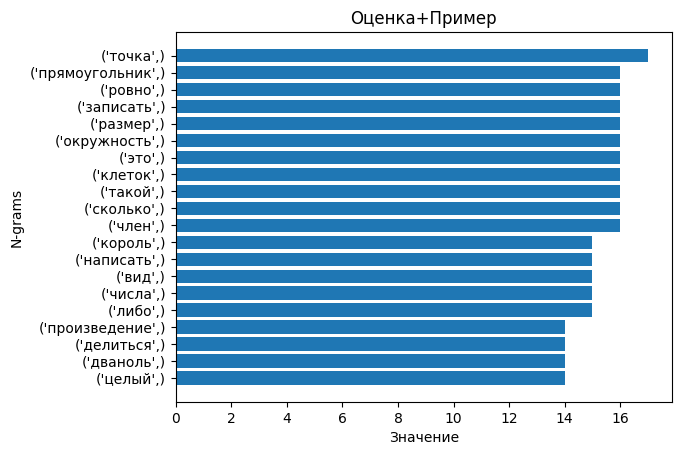

In [186]:
get_n_grams(data=data, topic='Оценка+Пример', n=1, k=20, start_slice=60)

In [187]:
assessment_plus_example = ["сумма", "каждый", "коробка",
                           "малый", "белый","больший", "набор",
                           "бить", "отметить", "больший количество",
                           "больший", "шахматный",
                           "клетка", 'квадрат', 'остальные', 'доска',
                           'число', 'сумма', 'квадрат', 'оказаться',
                           'черный', 'отметить', 'остаться',
                           'набор', 'записать', 'возможный', 'какой',
                           'какой малый', 'какой больший', 'больший количество',
                           'шахматный доска', 'возможный', 'малый возможный',
                           'найти малый', 'какой минимальный', 'минимальный',
                           'максимальный', 'какой максимальный', 'последовательность',
                           'получить', 'король', 'размер', 'клетка'
                          ]

### Отбор

In [ ]:
# Добавляем отобранные слова
data = data[['task', 'topic', 'new_task']]
data_6 = add_keywords(df=data, keywords=assessment_plus_example, column_name='task')

In [189]:
data_6.to_csv("assessment_plus_example.csv", sep='@')

In [190]:
# Обучаем на всех признаках
data = data[['task', 'topic', 'new_task']]
data_6_1 = data_6[[column for column in data_6.columns if column != 'task' and 'title' not in column]]
data_6_2 = data_6_1.copy()

In [191]:
model, score = get_ml_metrics(data_6_2, name='Оценка+Пример', X_columns='new_task', y_columns='topic', tf_idf=False)
print(score)

0.5185185185185185


In [208]:
data_6 = pd.read_csv('assessment_plus_example.csv', sep='@').drop(columns=['Unnamed: 0', 'task'])

In [209]:
model, score = get_ml_metrics(data_6, name='Оценка+Пример', X_columns='new_task', y_columns='topic', tf_idf=True)
print(score)

0.5494505494505495


In [192]:
len(data_6_2.columns)

36

In [174]:
data_6[data_6.topic == 'Оценка+Пример'].to_csv('Оценка+Пример.csv')

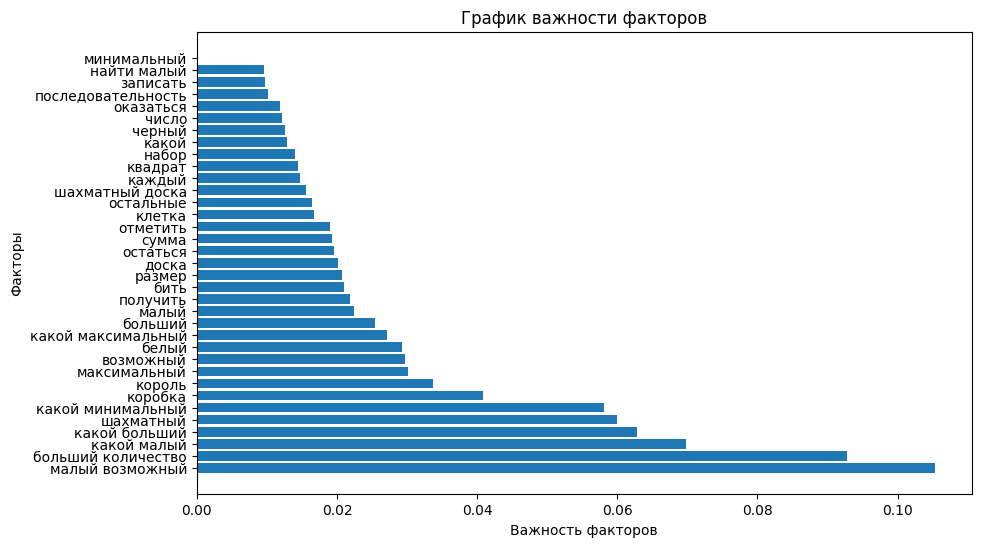

In [193]:
columns_to_train = visualization_feature_importances(model=model, data=data_6_2, top_k=35)

In [194]:
max_score = 0
best_top_k = 0
columns_to_train = columns_to_train + ['y']
for top_k in range(0, len(data_6_2.columns) - 1):
    data_1_3 = data_6_2[columns_to_train[top_k:]]
    model, score = get_ml_metrics(data_1_3, name='Оценка+Пример', X_columns='new_task',
                                  y_columns='topic', tf_idf=False, need_processin=False)
    if score >= max_score:
      max_score = score
      best_top_k = len(data_6_2.columns) - 1 - top_k
    print(f"iter - {top_k}, первая колонка - {columns_to_train[top_k:][0]}, score - {score}, max_score - {max_score}")

iter - 0, первая колонка - минимальный, score - 0.5185185185185185, max_score - 0.5185185185185185
iter - 1, первая колонка - найти малый, score - 0.5185185185185185, max_score - 0.5185185185185185
iter - 2, первая колонка - записать, score - 0.4807692307692308, max_score - 0.5185185185185185
iter - 3, первая колонка - последовательность, score - 0.5142857142857142, max_score - 0.5185185185185185
iter - 4, первая колонка - оказаться, score - 0.5, max_score - 0.5185185185185185
iter - 5, первая колонка - число, score - 0.4854368932038835, max_score - 0.5185185185185185
iter - 6, первая колонка - черный, score - 0.3838383838383838, max_score - 0.5185185185185185
iter - 7, первая колонка - какой, score - 0.4, max_score - 0.5185185185185185
iter - 8, первая колонка - набор, score - 0.41304347826086957, max_score - 0.5185185185185185
iter - 9, первая колонка - квадрат, score - 0.3956043956043956, max_score - 0.5185185185185185
iter - 10, первая колонка - каждый, score - 0.3655913978494624, 

In [ ]:
assessment_plus_final = ["сумма", "каждый", "коробка",
                           "малый", "белый","больший", "набор",
                           "бить", "отметить", "больший количество",
                           "больший", "шахматный",
                           "клетка", 'квадрат', 'остальные', 'доска',
                           'число', 'сумма', 'квадрат', 'оказаться',
                           'черный', 'отметить', 'остаться',
                           'набор', 'записать', 'возможный', 'какой',
                           'какой малый', 'какой больший', 'больший количество',
                           'шахматный доска', 'возможный', 'малый возможный',
                           'найти малый', 'какой минимальный', 'минимальный',
                           'максимальный', 'какой максимальный', 'последовательность',
                           'получить', 'король', 'размер', 'клетка'
                          ]

## Теория чисел

### Анализ

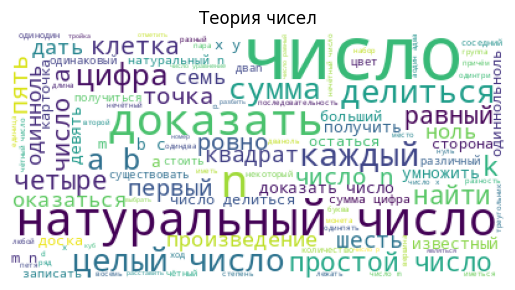

In [195]:
get_word_cloud(data=data, topic='Теория чисел')

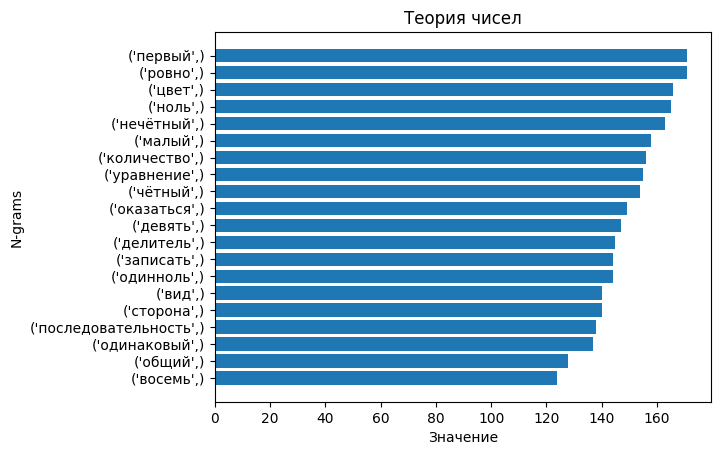

In [215]:
get_n_grams(data=data, topic='Теория чисел', n=1, k=20, start_slice=30)

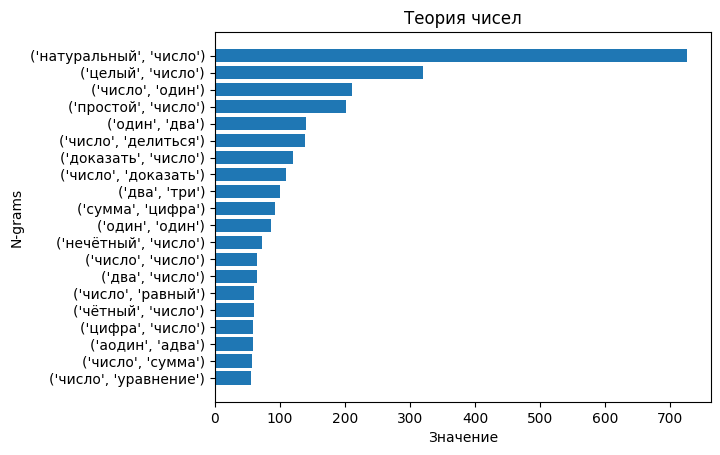

In [217]:
get_n_grams(data=data, topic='Теория чисел', n=2, k=20, start_slice=0)

In [219]:
number_theory = [
    "делится", "оканчивается", "подряд", "НОД", "НОК", "наименьшего общего кратного",
    "простой", "большой", "общий", 'натуральный число', 'произведение', 'степень',
    'умножение', 'вычитание', "сложение", "число", "цифра", 'целый', 'простой',
    'цифра', 'квадрат', 'делиться', 'равный', 'ноль', 'девять', 'разность', 'одинаковый',
    'четный', 'a', 'b', 'x', 'y', 'n', 'доказать', 'некоторый', 'порядок', 'решить',
    'mod', 'значение', 'нечетный', 'последовательность', 'одинаковый', 'натуральный число',
    'целый число', 'простой число', 'число делиться', 'сумма цифр', 'число доказать', 'доказать число'
]

### Отбор

In [220]:
# Добавляем отобранные слова
data = data[['task', 'topic', 'new_task']]
data_7 = add_keywords(df=data, keywords=number_theory, column_name='task')

100%|██████████| 5803/5803 [07:35<00:00, 12.75it/s]


In [221]:
data_7.to_csv("number_theory_1.csv", sep='@')

In [222]:
# Обучаем на всех признаках
data = data[['task', 'topic', 'new_task']]
data_7_1 = data_7[[column for column in data_7.columns if column != 'task' and 'title' not in column]]
data_7_2 = data_7_1.copy()

In [223]:
model, score = get_ml_metrics(data_7_2, name='Теория чисел', X_columns='new_task', y_columns='topic',
                              tf_idf=False)
print(score)

0.6434463794683777


### Анализ

In [224]:
len(data_7_2.columns)

45

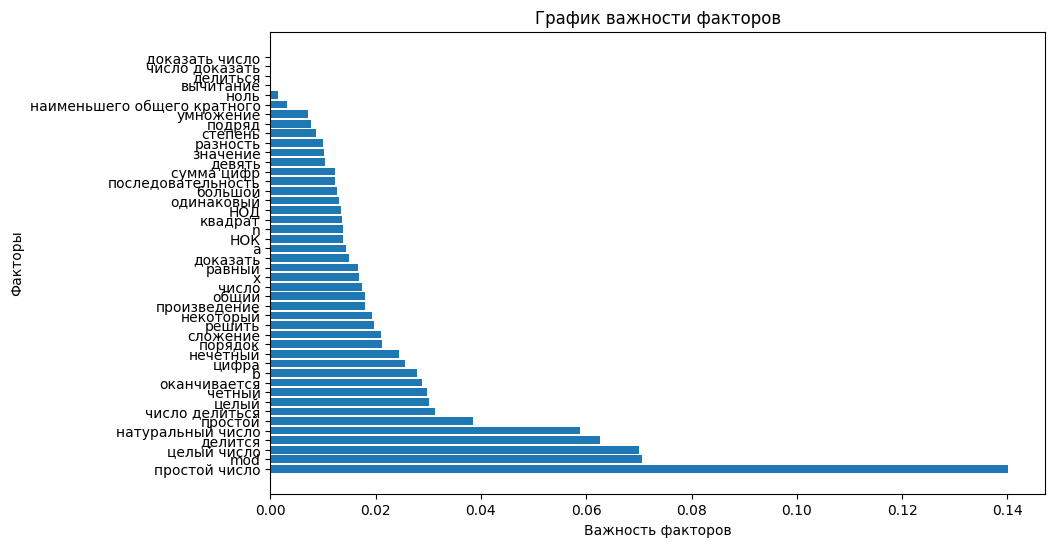

In [225]:
columns_to_train = visualization_feature_importances(model=model, data=data_7_2, top_k=44)

In [226]:
max_score = 0
best_top_k = 0
columns_to_train = columns_to_train + ['y']
for top_k in range(0, len(data_7_2.columns) - 1):
    data_1_3 = data_7_2[columns_to_train[top_k:]]
    model, score = get_ml_metrics(data_1_3, name='Теория чисел', X_columns='new_task',
                                  y_columns='topic', tf_idf=False, need_processin=False)
    if score >= max_score:
      max_score = score
      best_top_k = len(data_7_2.columns) - 1 - top_k
    print(f"iter - {top_k}, первая колонка - {columns_to_train[top_k:][0]}, score - {score}, max_score - {max_score}")

iter - 0, первая колонка - доказать число, score - 0.6357012750455373, max_score - 0.6357012750455373
iter - 1, первая колонка - число доказать, score - 0.6357012750455373, max_score - 0.6357012750455373
iter - 2, первая колонка - делиться, score - 0.6357012750455373, max_score - 0.6357012750455373
iter - 3, первая колонка - вычитание, score - 0.6357012750455373, max_score - 0.6357012750455373
iter - 4, первая колонка - ноль, score - 0.6357012750455373, max_score - 0.6357012750455373
iter - 5, первая колонка - наименьшего общего кратного, score - 0.6424021838034577, max_score - 0.6424021838034577
iter - 6, первая колонка - умножение, score - 0.6380255941499086, max_score - 0.6424021838034577
iter - 7, первая колонка - подряд, score - 0.6399270738377393, max_score - 0.6424021838034577
iter - 8, первая колонка - степень, score - 0.6334256694367497, max_score - 0.6424021838034577
iter - 9, первая колонка - разность, score - 0.6336996336996337, max_score - 0.6424021838034577
iter - 10, пер

In [230]:
number_theory_final = ['некоторый', 'решить', 'сложение', 'порядок',
                       'нечетный', 'цифра', 'b', 'оканчивается', 'четный',
                       'целый', 'число делиться', 'простой', 'натуральный число',
                       'делится', 'целый число', 'mod', 'простой число']

## Графы

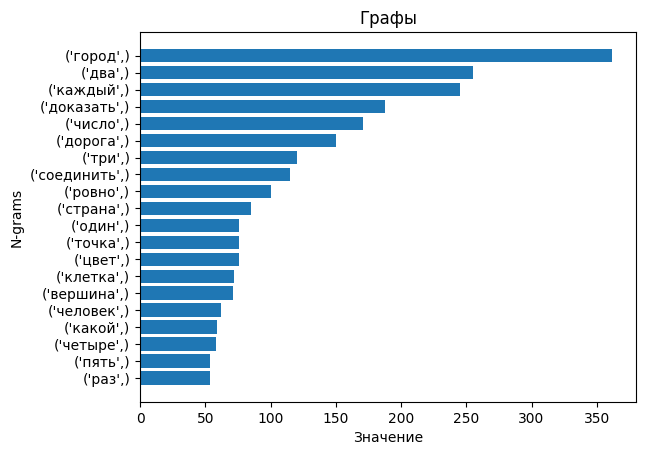

In [250]:
get_n_grams(data=data, topic='Графы', n=1, k=20, start_slice=0)

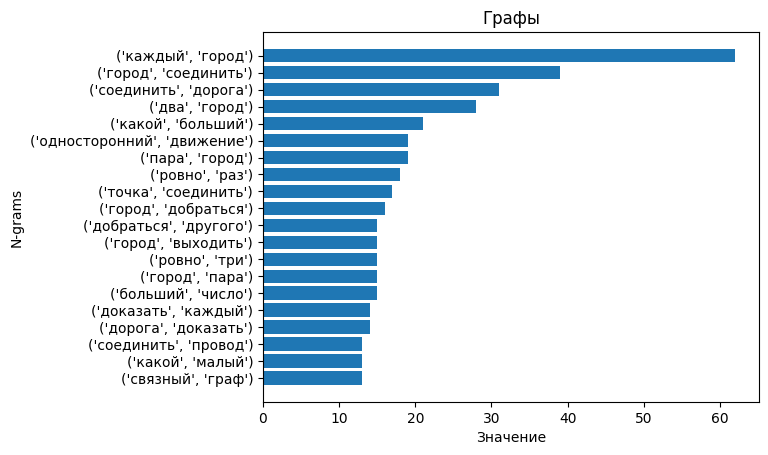

In [238]:
get_n_grams(data=data, topic='Графы', n=2, k=20, start_slice=0)

In [260]:
graphs = ['город', "ребро", "компания", "каждый город",
          "страна", "проехать", "знакомый", "соединить",
          'дорога', 'вершина', 'маршурт', 'отрезок',
         'человек', 'ход', 'проехать', 'команда',
         'горо соединить', 'граф', 'пара',
         'знакомый', 'добраться', 'связанный', 'движение',
         'страна город', 'телефон соединить', 'число человек',
         'город попасть', 'город дорога', 'город соединить',
         'пара город', 'город добраться', 'соединить провод',
         'провод', 'связанный граф']

### Отбор

In [241]:
# Добавляем отобранные слова
data = data[['task', 'topic', 'new_task']]
data_8 = add_keywords(df=data, keywords=graphs, column_name='task')

100%|██████████| 5803/5803 [05:16<00:00, 18.35it/s]


In [243]:
data_8.to_csv('graphs_1.csv', sep="@")

In [263]:
# Обучаем на всех признаках
data = data[['task', 'topic', 'new_task']]
data_8_1 = data_8[[column for column in data_8.columns if column != 'task' and 'title' not in column]]
data_8_2 = data_8_1.copy()

In [257]:
model, score = get_ml_metrics(data_8_2, name='Графы', X_columns='new_task', y_columns='topic',
                              tf_idf=False)
print(score)

0.08888888888888889


In [247]:
len(data_8_2.columns)

33

In [283]:
model, score = get_ml_metrics(data_8_2.drop(columns=['компания', 'отрезок',
                                                    'человек', 'команда',
                                                    'ребро']), name='Графы', X_columns='new_task', y_columns='topic',
                              tf_idf=False, accuracy=True)
print(score)

0.9159200551343901


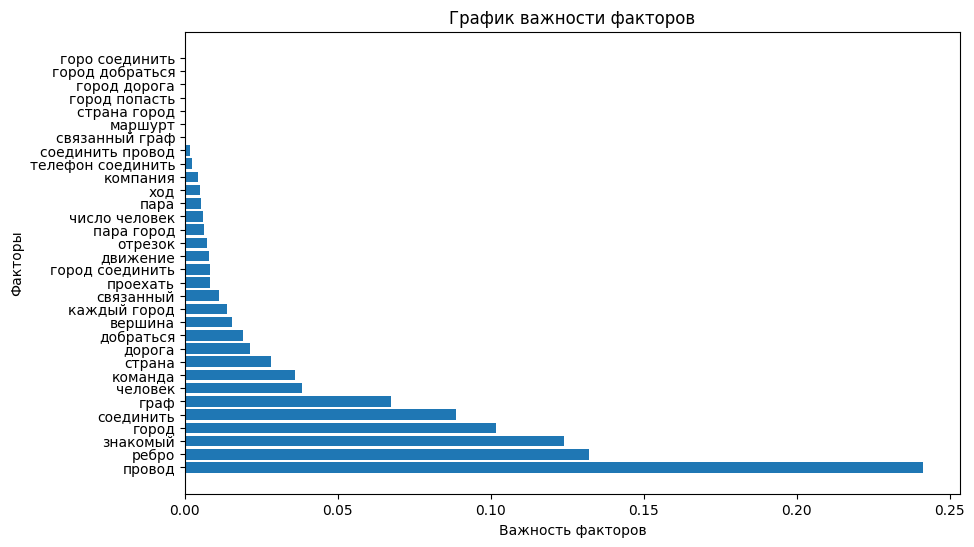

In [248]:
columns_to_train = visualization_feature_importances(model=model, data=data_8_2, top_k=32)

In [249]:
max_score = 0
best_top_k = 0
columns_to_train = columns_to_train + ['y']
for top_k in range(0, len(data_8_2.columns) - 1):
    data_1_3 = data_8_2[columns_to_train[top_k:]]
    model, score = get_ml_metrics(data_1_3, name='Графы', X_columns='new_task',
                                  y_columns='topic', tf_idf=False, need_processin=False)
    if score >= max_score:
      max_score = score
      best_top_k = len(data_8_2.columns) - 1 - top_k
    print(f"iter - {top_k}, первая колонка - {columns_to_train[top_k:][0]}, score - {score}, max_score - {max_score}")

iter - 0, первая колонка - горо соединить, score - 0.10218978102189781, max_score - 0.10218978102189781
iter - 1, первая колонка - город добраться, score - 0.10218978102189781, max_score - 0.10218978102189781
iter - 2, первая колонка - город дорога, score - 0.10218978102189781, max_score - 0.10218978102189781
iter - 3, первая колонка - город попасть, score - 0.10218978102189781, max_score - 0.10218978102189781
iter - 4, первая колонка - страна город, score - 0.10218978102189781, max_score - 0.10218978102189781
iter - 5, первая колонка - маршурт, score - 0.10218978102189781, max_score - 0.10218978102189781
iter - 6, первая колонка - связанный граф, score - 0.10218978102189781, max_score - 0.10218978102189781
iter - 7, первая колонка - соединить провод, score - 0.10218978102189781, max_score - 0.10218978102189781
iter - 8, первая колонка - телефон соединить, score - 0.10144927536231885, max_score - 0.10218978102189781
iter - 9, первая колонка - компания, score - 0.08823529411764706, max_

In [251]:
columns_to_train[15:]

['движение',
 'город соединить',
 'проехать',
 'связанный',
 'каждый город',
 'вершина',
 'добраться',
 'дорога',
 'страна',
 'команда',
 'человек',
 'граф',
 'соединить',
 'город',
 'знакомый',
 'ребро',
 'провод',
 'y']

In [ ]:
graphs_final = ['движение', 'город соединить', 'проехать',
                'связанный', 'каждый город', 'вершина',
                'добраться', 'дорога', 'страна', 'команда',
                'человек', 'граф', 'соединить', 'город', 'знакомый', 'провод',]

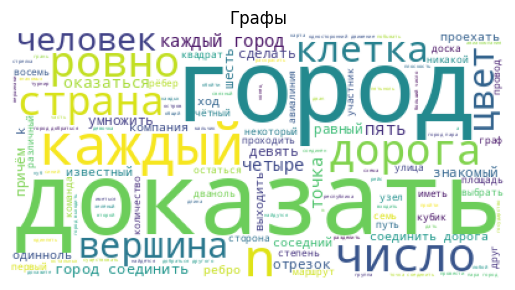

In [231]:
get_word_cloud(data=data, topic='Графы')